In [1]:
import os
import sys
import time as t_util
import numpy as np
import cftime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats
import matplotlib
import yaml


In [2]:
#Read main paths
with open('../path_main.txt', 'r') as file:    path_main  = file.read()
with open('../path_grids.txt', 'r') as file:   path_grids = file.read()

dir_ERA5    = f'{path_main}Data/ERA5-Land/JJA/'
dir_EOBS    = f'{path_main}Data/EOBS/JJA/'
dir_CORDEX  = f'{path_main}Data/EURO-CORDEX/JJA/'
dir_scripts = f'{path_main}Scripts/'
dir_names   = f'{path_main}Scripts/Model_lists/'
dir_regr    = f'{path_grids}Regridding/'
dir_fig     = f'{path_main}Figures/Paper_v2/'
if not os.path.exists(dir_fig): os.mkdir(dir_fig)
    

## Prepare variables and parameters

In [3]:
#Define cities
cities = ['Lisbon', 'Madrid', 'Barcelona', 'Rome', 'Athens', 'Istanbul', 'Sofia', 'Bucharest', 'Belgrade', 'Zagreb',
          'Milan', 'Budapest', 'Munich', 'Vienna', 'Prague', 'Paris', 'Brussels', 'Amsterdam', 'London', 'Dublin',
          'Hamburg', 'Copenhagen', 'Berlin', 'Warsaw', 'Kharkiv', 'Kyiv', 'Minsk', 'Vilnius', 'Riga', 'Moscow',
          'NizhnyNovgorod', 'Kazan', 'SaintPetersburg', 'Helsinki', 'Stockholm', 'Oslo']

#Define output names
cities_out = ['Nizhny Novgorod' if city=='NizhnyNovgorod' else
              'Saint Petersburg' if city=='SaintPetersburg' else city for city in cities]

#Define variables
variables = ['tasmax', 'tasmin']
vars_ERA5 = ['maxtemp2m', 'mintemp2m']
vars_EOBS = ['tx', 'tn']
vars_out  = ['TX', 'TN']

# Load city coordinates
fname_coords = dir_scripts + 'City_coordinates.yml'
with open(fname_coords, 'r') as file:
    city_coords = yaml.safe_load(file)

#Define models and RCPs which should be used
all_models = dict()
all_models = []
with open(dir_names + 'Models_CORDEX-EUR-11_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        all_models.append(eval(line[:-1]))


In [4]:
def get_city_data(data, city, city_coords, N, var_name, data_source):
    
    #Convert longitude from [0, 360] to [-180, 180]
    if 'longitude' in data.coords:  lat_name, lon_name = 'latitude', 'longitude'
    elif 'lon' in data.coords:      lat_name, lon_name = 'lat', 'lon'
    if data[lon_name].max()>180:
        data[lon_name] = data[lon_name].where(data[lon_name]<180, ((data[lon_name] + 180) % 360) - 180)

    #Get lat and lon of city
    lat_sel, lon_sel = city_coords[city]
    
    #Find grid point closest to city
    if data_source in ['EOBS', 'ERA5-Land']:
        
        #Find grid point closest to city
        lat_city = np.argmin(np.abs(data[lat_name].values - lat_sel))
        lon_city = np.argmin(np.abs(data[lon_name].values - lon_sel))

        #Select NxN box around grid point
        N_half = int((N-1)/2)
        lat_rng  = slice(lat_city - N_half, lat_city + N_half + 1)
        lon_rng  = slice(lon_city - N_half, lon_city + N_half + 1)
        data_sel = data.isel(latitude=lat_rng, longitude=lon_rng)        
        
    elif data_source=='EURO-CORDEX':

        #Find grid point closest to city
        loc_city = (np.abs(data[lon_name] - lon_sel)) + (np.abs(data[lat_name] - lat_sel))
        ind_city = np.unravel_index(np.argmin(loc_city.values), loc_city.shape)

        #Select NxN box around grid point
        N1 = int(N/2 - 0.5)
        N2 = int(N/2 + 0.5)
        lat_rng  = slice(ind_city[0] - N1, ind_city[0] + N2)
        lon_rng  = slice(ind_city[1] - N1, ind_city[1] + N2)
        
    else:
        
        sys.exit('Data source not defined')

    if 'rlat' in data.dims:   data_city = data.isel(rlat=lat_rng, rlon=lon_rng)
    elif 'x' in data.dims:    data_city = data.isel(y=lat_rng, x=lon_rng)
    else:                     data_city = data.isel(latitude=lat_rng, longitude=lon_rng)

    #Calculate distance from city center
    dist = np.sqrt((data_city[lat_name] - lat_sel)**2 + (data_city[lon_name] - lon_sel)**2)                

    #Convert K to °C
    if data_city[var_name].mean()>200:
        data_city = data_city - 273.15

    return(data_city, dist)


## Prepare data

In [5]:
#Define indicators
indicators = ['JJA-Q50', 'JJA-Q99']

#Define gridpoints (NxN) that should be included
N_gridpoints = [3]#, 5, 7, 9]

#Dictionary for storing bias data
coll_data = dict()

#Loop over indicators
for indicator in indicators:

    print(indicator)
    
    #Loop over number of considered gridpoints
    for N in N_gridpoints:
        
        print(" -" + str(N), end=': ')
        
        #Loop over variables
        for variab, var_ERA5, var_EOBS in zip(variables, vars_ERA5, vars_EOBS):

            print(variab, end=', ')

            #Initialize data frame for collecting data
            models_str   = ["_".join(model) for model in all_models]
            insert       = np.empty((len(models_str), len(cities))) * np.NaN
            data_pd_COR1 = pd.DataFrame(data=insert, index=models_str, columns=cities)    
            
            #Initialize data frame for collecting data
            models_str   = ["_".join(model) for model in all_models]
            insert       = np.empty((len(models_str), len(cities))) * np.NaN
            data_pd_COR2 = pd.DataFrame(data=insert, index=models_str, columns=cities)    
            
            #Initialize data frame for collecting ERA5 data
            models_str   = ["_".join(model) for model in all_models]
            insert       = np.empty((len(models_str), len(cities))) * np.NaN                
            data_pd_ERA5 = pd.DataFrame(data=insert, index=models_str, columns=cities)
            
            #Initialize data frame for collecting EOBS data
            models_str   = ["_".join(model) for model in all_models]
            insert       = np.empty((len(models_str), len(cities))) * np.NaN                
            data_pd_EOBS = pd.DataFrame(data=insert, index=models_str, columns=cities)            
            
            #Define folders
            dir_data_CORD = dir_CORDEX + variab + '/'
            dir_data_ERA5 = dir_ERA5 + var_ERA5 + '/'
            dir_data_EOBS = dir_EOBS + var_EOBS + '/'

            #Get file name for ERA5 data
            fnames_ERA5 = [dir_data_ERA5 + file for file in os.listdir(dir_data_ERA5) if indicator in file and '1981-2010' in file]
            if len(fnames_ERA5)!=1:  sys.exit('Filename not unique')
            fname_ERA5 = fnames_ERA5[0]
            
            #Get file name for EOBS data
            fnames_EOBS = [dir_data_EOBS + file for file in os.listdir(dir_data_EOBS) if indicator in file and '1981-2010' in file]
            if len(fnames_EOBS)!=1:  sys.exit('Filename not unique')
            fname_EOBS = fnames_EOBS[0]

            #Loop over models
            for i1, model in enumerate(all_models):         

                #Read CORDEX data
                fnames = [file for file in os.listdir(dir_data_CORD) if model[0] in file and model[1] in file and model[2] in file]
                fnames = [file for file in fnames if indicator in file and '1981-2010' in file and 'masked-sea' not in file]
                if len(fnames)!=1:  sys.exit('Filename not unique')
                data_CORD = xr.open_dataset(dir_data_CORD + fnames[0])

                #Regrid ERA5 to CORDEX model grid and read regridded ERA5 data 
                file_grid = dir_regr + 'grid_xy_CORDEX-EUR-11_' + model[0] + '_' + model[1]
                fname_ERA5_regr = dir_ERA5 + 'ERA5_regrid_' + variab + "_" + "_".join(model) + '_' + indicator + '_' + str(N) + '.nc'
                os.system("cdo remapbil," + file_grid + " " + fname_ERA5 + " " + fname_ERA5_regr)
                data_ERA5 = xr.open_dataset(fname_ERA5_regr)

                #Regrid EOBS to CORDEX model grid and read regridded EOBS data 
                file_grid = dir_regr + 'grid_xy_CORDEX-EUR-11_' + model[0] + '_' + model[1]
                fname_EOBS_regr = dir_EOBS + 'EOBS_regrid_' + variab + "_" + "_".join(model) + '_' + indicator + '_' + str(N) + '.nc'
                os.system("cdo remapbil," + file_grid + " " + fname_EOBS + " " + fname_EOBS_regr)
                data_EOBS = xr.open_dataset(fname_EOBS_regr)

                #Loop over cities
                for city in cities:

                    #Get data in cities
                    data_city_CORD, _ = get_city_data(data_CORD, city, city_coords, N, variab, 'EURO-CORDEX')
                    data_city_ERA5, _ = get_city_data(data_ERA5, city, city_coords, N, var_ERA5, 'EURO-CORDEX')
                    data_city_EOBS, _ = get_city_data(data_EOBS, city, city_coords, N, var_EOBS, 'EURO-CORDEX')

                    #Get lat and lon names
                    if 'rlat' in data_city_CORD.dims:
                        lat_name = 'rlat'
                        lon_name = 'rlon'
                    elif 'x' in data_city_CORD.dims:
                        lat_name = 'x'
                        lon_name = 'y'      
                    else:
                        sys.exit('Lat and lon names undefined')
                        
                    #Check distance of ERA5
                    check1 = np.max(np.abs(data_city_ERA5[lat_name].values - data_city_CORD[lat_name].values))
                    check2 = np.max(np.abs(data_city_ERA5[lon_name].values - data_city_CORD[lon_name].values))
                    if (check1>0.0001) or (check2>0.0001):
                        sys.exit('Coordinates do not agree')
                    if (check1>0) or (check2>0):
                        data_city_ERA5 = data_city_ERA5.reindex({lat_name: data_city_CORD[lat_name], lon_name: data_city_CORD[lon_name]}, method='nearest')

                    #Check distance of EOBS
                    check1 = np.max(np.abs(data_city_EOBS[lat_name].values - data_city_CORD[lat_name].values))
                    check2 = np.max(np.abs(data_city_EOBS[lon_name].values - data_city_CORD[lon_name].values))
                    if (check1>0.0001) or (check2>0.0001):
                        sys.exit('Coordinates do not agree')
                    if (check1>0) or (check2>0):
                        data_city_EOBS = data_city_EOBS.reindex({lat_name: data_city_CORD[lat_name], lon_name: data_city_CORD[lon_name]}, method='nearest')
            
                    #Apply ERA5 masking to CORDEX
                    mask = ~np.isnan(data_city_ERA5[var_ERA5])
                    data_city_CORD_ERA5mask = data_city_CORD.where(mask)
                        
                    #Apply EOBS masking to CORDEX
                    mask = ~np.isnan(data_city_EOBS[var_EOBS])
                    data_city_CORD_EOBSmask = data_city_CORD.where(mask)                        
                        
                    #Save in array
                    data_pd_COR1.loc["_".join(model), city] = data_city_CORD_ERA5mask[variab].mean()
                    data_pd_COR2.loc["_".join(model), city] = data_city_CORD_EOBSmask[variab].mean()
                    data_pd_ERA5.loc["_".join(model), city] = data_city_ERA5[var_ERA5].mean()
                    data_pd_EOBS.loc["_".join(model), city] = data_city_EOBS[var_EOBS].mean()

                #Remove temporary regridded file
                os.remove(fname_ERA5_regr)
                os.remove(fname_EOBS_regr)

            #Collect in dict
            coll_data[variab + '_' + indicator + '_' + str(N) + '_CORDEX_ERA5-mask'] = data_pd_COR1
            coll_data[variab + '_' + indicator + '_' + str(N) + '_CORDEX_EOBS-mask'] = data_pd_COR2
            coll_data[variab + '_' + indicator + '_' + str(N) + '_ERA5']             = data_pd_ERA5
            coll_data[variab + '_' + indicator + '_' + str(N) + '_EOBS']             = data_pd_EOBS

        print('')

JJA-Q50
 -3: tasmax, 

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.94s 273MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.91s 274MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.59s 239MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 252MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.60s 252MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.60s 252MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 252MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 252MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.92s 274MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.63s 252MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 252MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 252MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 253MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 253MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (453x453) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [1.08s 319MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB]

tasmin, 

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.92s 274MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.92s 274MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.59s 254MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.60s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.60s 254MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.22s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.91s 274MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.60s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.22s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.22s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (453x453) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [1.05s 319MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.22s 254MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 254MB]


JJA-Q99
 -3: tasmax, 

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.91s 273MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.93s 274MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.60s 255MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 255MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.61s 255MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.61s 255MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.22s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.92s 274MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.60s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.22s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (453x453) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [1.06s 319MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145851)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.24s 257MB]

tasmin, 

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.92s 274MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.93s 273MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.60s 257MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.60s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.61s 257MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.92s 274MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.61s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (453x453) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [1.07s 319MB]

Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.24s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (701x351) to curvilinear (424x412) grid, with source mask (162664)
cdo    remapbil: Processed 246051 values from 1 variable over 1 timestep [0.23s 257MB].
Warning (find_time_vars): Time variable >time< not found!
Warning (cdfInqContents): Coordinates variable quantile can't be assigned!
cdo    remapbil: Bilinear weights from lonlat (705x465) to curvilinear (424x412) grid, with source mask (145619)
cdo    remapbil: Processed 327825 values from 1 variable over 1 timestep [0.23s 257MB]

## Plot preparation

In [6]:
wid = 0.5

texts   = ['a)', 'b)', 'c)', 'd)']

#Function for coloring boxplots
def color_boxes(bp_handle, color, alpha=1):

    #Color boxes
    for patch in bp_handle['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(alpha)

    for item in bp_handle['whiskers'][0::2]:
        item.set_color(color)
        item.set_alpha(alpha)

    for item in bp_handle['whiskers'][1::2]:
        item.set_color(color)
        item.set_alpha(alpha)

    for item in bp_handle['boxes']:
        item.set_color(color)
        item.set_alpha(alpha)


## Plot comparison to ERA5-Land

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216

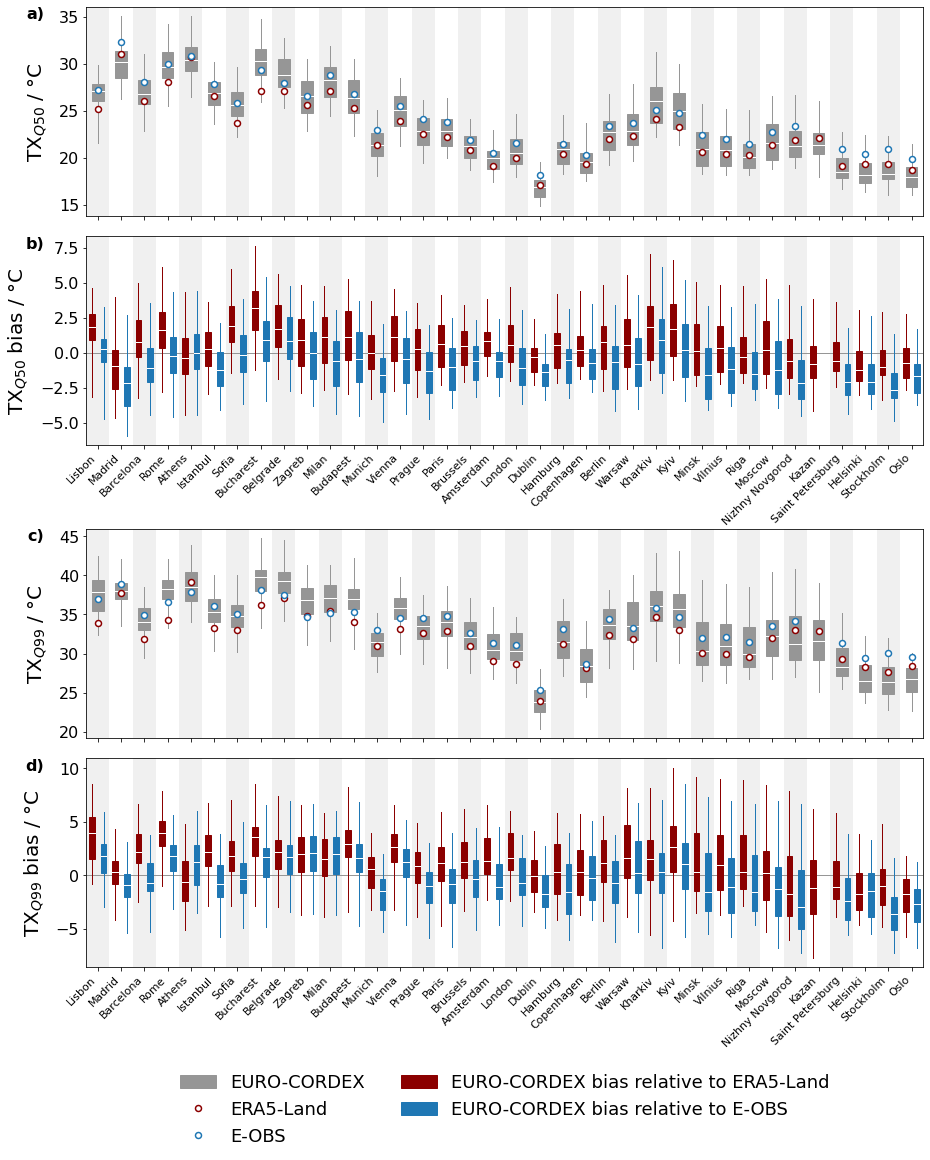

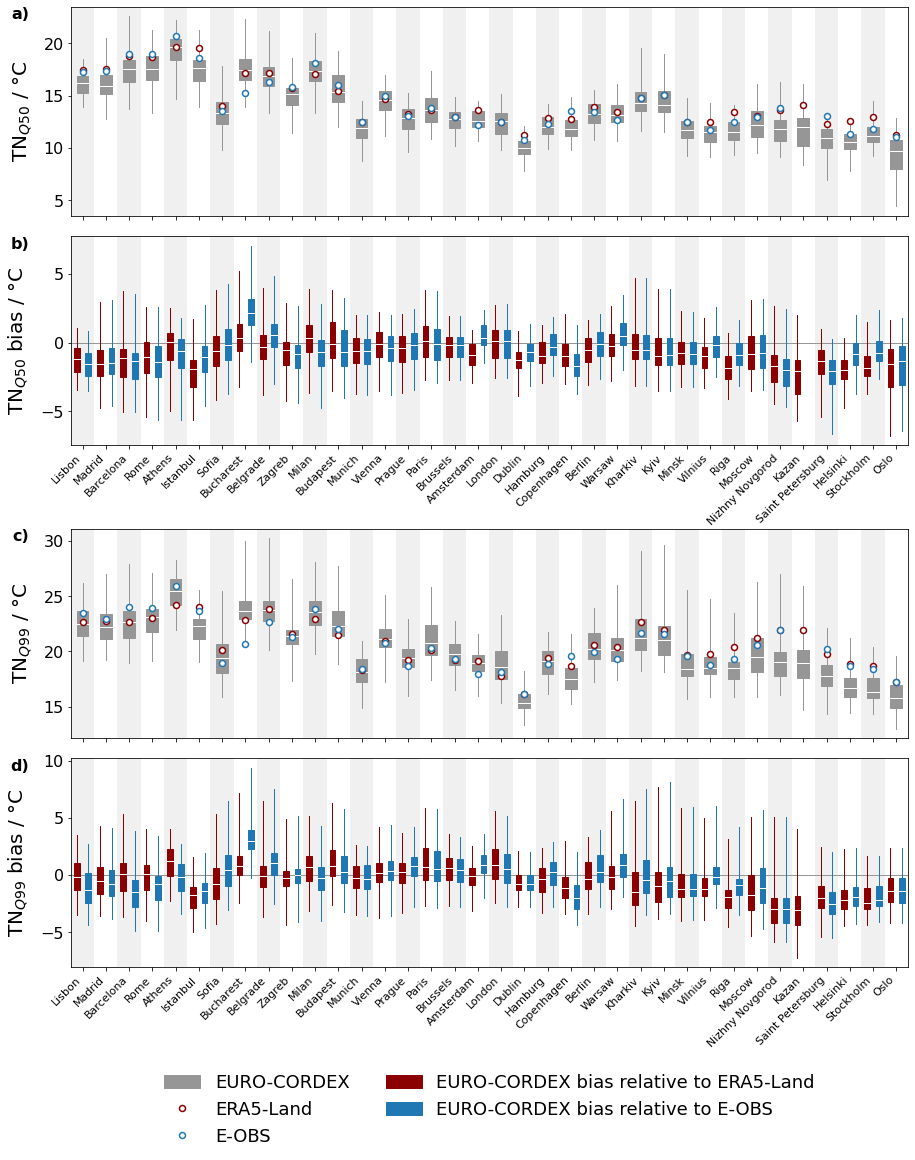

In [7]:
#Define indicators
indicators_plot = ['JJA-Q50', 'JJA-Q99']

N_points = 3

#Loop over variables
coll_bias = dict()
for variab, var_out in zip(variables, vars_out):

    #Create dataframe for collecting biases
    coll_bias[var_out] = pd.DataFrame(index=cities, columns=[f'{var_out}-bias_ERA5-Land', f'{var_out}-bias_E-OBS'])   
    
    #Create figure
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))
    plt.subplots_adjust(hspace=0.4)

    #Define colors
    if variab=='huss':
        unit = '[kg/kg]'
    else:
        unit = '/ °C'
        
    #Reset list for y-labels
    ylabels = []
         
    #Loop over indicators
    for i0, indicator in enumerate(indicators_plot):

        #Create y-label
        if '-Q' in indicator:lab_add = '$_{' + indicator[-3::] + '}$'
        else:                lab_add = ''
        ylabels.append(var_out + lab_add +' ' + unit)
        ylabels.append(var_out + lab_add + ' bias ' + unit)

        #Select data
        data_plot_COR1 = coll_data[variab + '_' + indicator + '_' + str(N_points) + '_CORDEX_ERA5-mask']
        data_plot_COR2 = coll_data[variab + '_' + indicator + '_' + str(N_points) + '_CORDEX_EOBS-mask']
        data_plot_ERA5 = coll_data[variab + '_' + indicator + '_' + str(N_points) + '_ERA5']
        data_plot_EOBS = coll_data[variab + '_' + indicator + '_' + str(N_points) + '_EOBS']
        
        
        #Loop over cities
        for i1, city in enumerate(cities):

            #Get data
            val_COR1 = data_plot_COR1[city]
            val_COR2 = data_plot_COR2[city]
            val_ERA5 = data_plot_ERA5[city]
            val_EOBS = data_plot_EOBS[city]
            val_diff1 = val_COR1 - val_ERA5
            val_diff2 = val_COR2 - val_EOBS
            
            #Collect biases
            if indicator=='JJA-Q50':
                coll_bias[var_out].loc[city, f'{var_out}-bias_ERA5-Land'] = val_diff1.median()
                coll_bias[var_out].loc[city, f'{var_out}-bias_E-OBS'] = val_diff2.median()

            ax = axes[2*i0]

            #Plot absolute values
            bp1 = ax.boxplot(val_COR1, whis=[0, 100], sym='', positions=[i1],
                            capprops=dict(color='none'), widths=wid, patch_artist=True, manage_ticks=False, zorder=10)

            #Plot ERA5 markers
            p1 = ax.plot(i1, val_ERA5.median(), 'o', color='white', markeredgecolor='darkred', markeredgewidth=1.5, zorder=20)
            
            #Plot EOBS markers
            p2 = ax.plot(i1, val_EOBS.median(), 'o', color='white', markeredgecolor='tab:blue', markeredgewidth=1.5, zorder=20)

            #Color boxes and medians
            color_boxes(bp1, '#969696')
            for median in bp1['medians']:  median.set(color='w')

            ax = axes[2*i0 + 1]            
            
            #Plot bias
            bp2 = ax.boxplot(val_diff1, whis=[0, 100], sym='', positions=[i1-0.25],
                            capprops=dict(color='none'), widths=wid/2, patch_artist=True, manage_ticks=False, zorder=10)

            #Plot bias
            bp3 = ax.boxplot(val_diff2, whis=[0, 100], sym='', positions=[i1+0.25],
                            capprops=dict(color='none'), widths=wid/2, patch_artist=True, manage_ticks=False, zorder=10)

            #Color boxes and medians
            color_boxes(bp2, 'darkred')
            color_boxes(bp3, 'tab:blue')
            for median in bp2['medians']:median.set(color='w')
            for median in bp3['medians']:median.set(color='w')

            #Plot zero-line
            ax.plot([-5, len(cities) + 5], [0, 0], '#969696', linewidth=0.5)
                
            #Set background color
            if np.mod(i1,2)==0:
                axes[2*i0].axvspan(i1 - 0.5, i1 + 0.5, facecolor='#f0f0f0')
                axes[2*i0 + 1].axvspan(i1 - 0.5, i1 + 0.5, facecolor='#f0f0f0')

    #Loop over axes
    for i2, ax in enumerate(axes):
               
        #Set limits and size of ticks
        xlims = [-0.5 , len(cities) - 0.5]
        ax.set_xlim(xlims)
        ax.tick_params(labelsize=16)

        #Set position
        pos = ax.get_position()
        if i2>=3:
            pos.y1 = pos.y1 + 0.088
            pos.y0 = pos.y0 + 0.088
            ax.set_position(pos)

        elif i2>=1:
            pos.y1 = pos.y1 + 0.044
            pos.y0 = pos.y0 + 0.044
            ax.set_position(pos)
        
        #Write letters
        ax.text(-0.05, 1.00, texts[i2], fontsize=16, fontweight='bold', va='top', ha='right', transform=ax.transAxes)
        
        #Ticks and labels
        ax.set_ylabel(ylabels[i2], fontsize=20, labelpad=10)
        ax.set_xticks(np.arange(0, len(cities_out), 1))
        if np.mod(i2, 2)==1:          
            ax.set_xticklabels(cities_out, rotation=45, ha='right', fontsize=11)
        else:
            ax.set_xticklabels([], rotation=45, ha='right', fontsize=11)
    
    #Legend 
    ax.legend([bp1["boxes"][0], p1[0], p2[0], bp2["boxes"][0], bp3["boxes"][0]], ['EURO-CORDEX', 'ERA5-Land', 'E-OBS', 'EURO-CORDEX bias relative to ERA5-Land', 'EURO-CORDEX bias relative to E-OBS'],
              fontsize=18, frameon=False, ncol=2, loc=8, bbox_to_anchor=(0.5, -0.93))

    #Save figure
    if variab=='tasmax':  fig_name = 'FigS1'
    else:                 fig_name = 'FigS'
    fig.savefig(dir_fig + fig_name + '_CORDEX_ERA5_comparison_' + variab + '.png', bbox_inches='tight', dpi=300)


## Plot map with biases

/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/uio/kant/div-cicero-u1/clems/.conda/envs/python38_clems_2021_qbo/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of

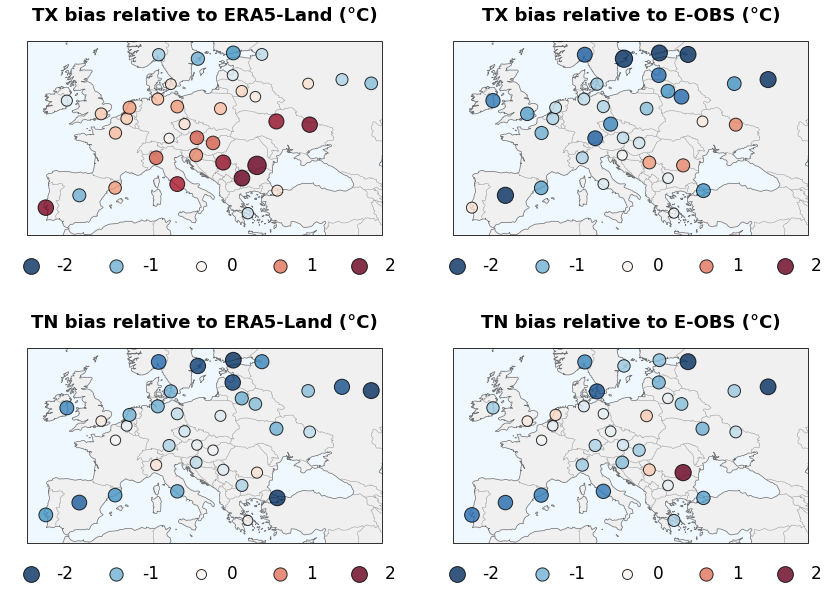

In [8]:
#Define plot parameters and colormap
sc_scale  = 300
vmin      = -2
vmax      = 2
sc_offset = 100
edgecolor = 'k'
alpha     = 0.8
cmap      = matplotlib.cm.get_cmap('RdBu_r', len(cities))
colors    = cmap(np.linspace(0, 0.9,  len(cities)))   

#Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(projection=ccrs.Robinson()))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

#Define reference datasets
ref_datasets = ['ERA5-Land', 'E-OBS']

#Loop over variables
for ii, var_out in enumerate(vars_out):

    #Loop over reference datasets
    for jj, ref_data in enumerate(ref_datasets):
    
        ax = axes[ii, jj]
        
        #Add coastlines and borders
        ax.coastlines(resolution='50m', linewidth=0.75, color='#737373', zorder=0)
        ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
        ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='#969696', zorder=0)
        ax.set_extent([-12, 45, 35, 62], crs=ccrs.PlateCarree())
        ax.spines['geo'].set_zorder(30)

        #Loop over cities
        x = [];  y = []; val = []
        for city in cities:
            
            #Add city coordinates and bias to lists
            x.append(city_coords[city][1])
            y.append(city_coords[city][0])
            val.append(coll_bias[var_out].loc[city, f'{var_out}-bias_{ref_data}'])

        #Convert list to array
        val = np.array(val)
        
        #Scatter plot
        sc = ax.scatter(x, y, s=sc_scale*np.abs((val)/(vmax-vmin)) + sc_offset, transform=ccrs.PlateCarree(),
                        color=cmap((val-vmin)/(vmax-vmin)), edgecolor=edgecolor, cmap=cmap, vmax=vmax, vmin=vmin, alpha=alpha)

        #Create helper plot for legend
        val_h = np.arange(vmin, vmax+1, 1)
        x_h = np.ones(len(val_h))
        y_h = np.ones(len(val_h))    
        for x, y, v in zip(x_h, y_h, val_h):

            sc_h = ax.scatter(x, y, s=sc_scale*np.abs((v)/(vmax-vmin)) + sc_offset, transform=ccrs.PlateCarree(),
                              color=cmap((v-vmin)/(vmax-vmin)), edgecolor=edgecolor, label=v, alpha=alpha)


        #Set title
        ax.set_title(f'{var_out} bias relative to {ref_data} (°C)', fontsize=18, fontweight='bold', pad=20) 
            
        #Legend
        legend = ax.legend(fontsize=17, bbox_to_anchor=(0.5, -0.28), frameon=False, loc='lower center',
                           labelspacing=1, columnspacing=1.5, handletextpad=0.5, ncol=len(val_h))

#Save figure
fig.savefig(dir_fig + 'FigS1b_CORDEX-bias_wrt-ERA5-EOBS_map.png', bbox_inches='tight', dpi=300)


## Print biases

In [9]:
print(coll_bias['TX'].mean(axis=0))
coll_bias['TX'].sort_values('TX-bias_ERA5-Land')


TX-bias_ERA5-Land    0.509816
TX-bias_E-OBS       -0.835726
dtype: float64


,TX-bias_ERA5-Land,TX-bias_E-OBS
Helsinki,-1.217607,-2.037646
Stockholm,-0.991767,-2.654572
Madrid,-0.923508,-2.170687
Kazan,-0.813363,NaN
Oslo,-0.687672,-1.618039
NizhnyNovgorod,-0.588895,-2.115859
SaintPetersburg,-0.554725,-2.09459
Athens,-0.382666,-0.023112
Dublin,-0.31305,-1.364326
Riga,-0.255297,-1.486166


In [10]:
print(coll_bias['TN'].mean(axis=0))
coll_bias['TN'].sort_values('TN-bias_ERA5-Land')


TN-bias_ERA5-Land   -0.839135
TN-bias_E-OBS       -0.609989
dtype: float64


,TN-bias_ERA5-Land,TN-bias_E-OBS
Kazan,-2.061345,NaN
Helsinki,-1.963538,-0.852693
Istanbul,-1.931528,-1.042505
Riga,-1.874808,-0.925004
Stockholm,-1.836772,-0.729162
NizhnyNovgorod,-1.741685,-1.987241
Madrid,-1.592884,-1.458841
Oslo,-1.55066,-1.322446
SaintPetersburg,-1.321511,-2.043679
Dublin,-1.256068,-0.695632
